In [1]:
# Common imports 
from ast import literal_eval

import gensim
import numpy as np
import pandas as pd

from categorical_em import CategoricalEM
import sys
print(sys.version)

3.7.5 (default, Oct 25 2019, 15:51:11) 
[GCC 7.3.0]


## 1. Hyperparameters


In [2]:
K = 5 # Number of mixture components
I = 120 # Number of words in the dictionary
N = None # Number of documents

## 2. Load and preprocess the data

First, we need to load the data from the csv. This file contains the documents already processed and cleaned after applying the following steps:

1. Tokenization
2. Homogeneization, which includes:
    1. Removing capitalization.
    2. Removing non alphanumeric tokens (e.g. punktuation signs)
    3. Stemming/Lemmatization.
3. Cleaning
4. Vectorization


We load it as a `pandas` dataframe.


In [3]:
df = pd.read_csv('tweets_cleaned.csv')
df.drop_duplicates(subset="tweet", inplace=True)

df['tokens'] = df['tokens'].apply(literal_eval) #Transform the string into a list of tokens
X_tokens = list(df['tokens'].values)


In [4]:
print('Columns: {}\n'.format(' | '.join(df.columns.values)))

print('Tweet:\n{}'.format(df.loc[1, 'tweet']))
print('Tweet cleaned:\n{}'.format(df.loc[1, 'tweets_clean']))
print('Tweet tokens:\n{}'.format(X_tokens[1]))

Columns: tweet_id | timestamp | user_id | tweet | tweets_clean | tokens

Tweet:
OSINT people - please retweet, if possible. My friend is looking for women involved in OSINT. https://twitter.com/manisha_bot/status/1181594280336531457 …
Tweet cleaned:
osint people   please retweet  if possible  my friend is looking for women involved in osint
Tweet tokens:
['osint', 'peopl', 'retweet', 'possibl', 'friend', 'look', 'woman', 'involv', 'osint']


### Create the dictionary

Up to this point, we have transformed the raw text collection in a list of documents stored in `X_tokens`, where each document is a collection 
of the words that are most relevant for semantic analysis. Now, we need to convert these data (a list of token lists) into 
a numerical representation (a list of vectors, or a matrix). To do so, we will start using the tools provided by the `gensim` library. 

As a first step, we create a dictionary containing all tokens in our text corpus, and assigning an integer identifier to each one of them.



In [5]:
dictionary = gensim.corpora.Dictionary(X_tokens)

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=I)


### Create Bag of Words (BoW): Numerical version of documents
In the second step, let us create a numerical version of our corpus using the `doc2bow` method. In general, 
`D.doc2bow(token_list)` transforms any list of tokens into a list of tuples `(token_id, n)`, one per each token in 
`token_list`, where `token_id` is the token identifier (according to dictionary `D`) and `n` is the number of occurrences 
of such token in `token_list`. 

*Exercise:* Apply the `doc2bow` method from gensim dictionary `D`, to all tokens in every document in `X_tokens`. 
The result must be a new list named `X_bow` where each element is a list of tuples `(token_id, number_of_occurrences)`.

In [6]:
X_bow = list()
keep_tweet = list()
for tweet in X_tokens:
    tweet_bow = dictionary.doc2bow(tweet)
    if len(tweet_bow) > 1:
        X_bow.append(tweet_bow)
        keep_tweet.append(True)
    else:
        keep_tweet.append(False)

df_data = df[keep_tweet]

N = len(df_data)


Finally, we transform the BoW representation `X_bow` into a matrix, namely `X_matrix`, in which the i-th row and j-th column represents the 
number of occurrences of the j-th word of the dictionary in the i-th document. This will be the matrix used in the algorithm.

In [7]:
X_matrix = np.zeros([N, I])
for i, doc_bow in enumerate(X_bow):
    word_list = list()
    for word in doc_bow:
        X_matrix[i, word[0]] = word[1]


## 3. Categorical Mixture Model with Expectation Maximization

### Exercise 1: Analytical forms of the E and M steps for the EM-Algorithm
1. Write the joint distribution: $p(\{\mathbf{x}_n, z_n\}| \Theta) = ?$
2. Write the analytical expression for $Q(\Theta, \Theta^{\text{old}}) = ?$
3. Write the MLE for $\Theta$


#### Exercise 1.1

\begin{align}
p(\{\mathbf{x}_n, z_n\}| \Theta) &=  \cdots \\
\ln(p(\{\mathbf{x}_n, z_n\}| \Theta) &= \cdots = ... = \sum_{i=1}^N \left(\ln(\pi_{z_n}) + \sum_{j=1}^{W_n} \ln(\theta_{z_n x_{n_j}}) \right)
\end{align}

#### Exercise 1.2

\begin{align}
Q(\Theta, \Theta^{\text{old}}) = \cdots = \sum_{n=1}^N\sum_{k=1}^K p(z_n = k \vert x_n,\Theta^{old})\left(\ln(\pi_k) + \sum_{j=1}^{W_n} \ln(\theta_{kx_{n_j}})\right)\\
p(z_n = k \vert x_n,\Theta^{old}) = \cdots = \frac{\pi_k \prod_{i=1}^{W_n} \theta_{kx_{n_i}}^{old}}{\sum_{l=1}^K \pi_l \prod_{j=1}^{W_n}\theta_{kx_{n_j}}^{old}} \\
\end{align}

#### Exercise 1.3
\begin{align}
\hat{\pi}_k = \cdots = \frac{N_k}{N} = \frac{\sum_{n=1}^N p(z_n = k \vert x_n, \Theta^{old})}{N}
\end{align}

\begin{align}
\hat{\theta}_{km} = \cdots = \frac{\tilde{N}_{km}}{\tilde{N}_k} = \frac{\sum_{n=1}^N p(z_n = k \vert x_n, \Theta^{old}) c_{nm}}{\sum_{n=1}^N p(z_n = k \vert x_n, \Theta^{old}) W_n} = \frac{\sum_{n=1}^N p(z_n = k \vert x_n, \Theta^{old}) \sum_{j=1}^{W_n}[x_{n_j} = m]}{\sum_{n=1}^N p(z_n = k \vert x_n, \Theta^{old}) W_n}
\end{align}

### Exercise 2: Data anlysis task
#### Exercise 2.1

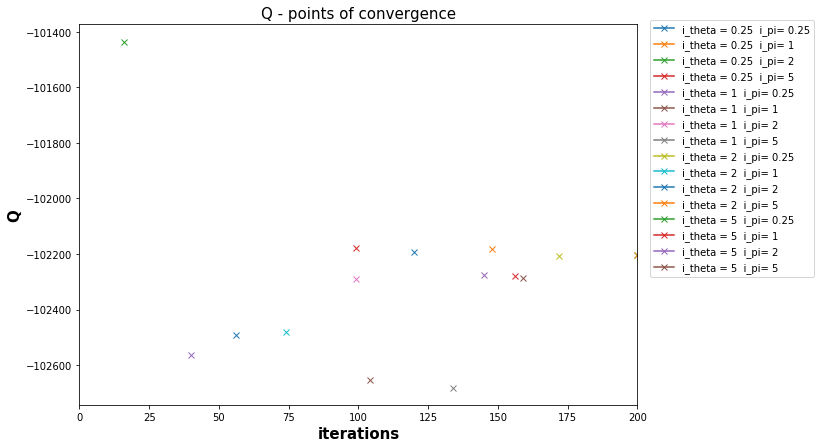

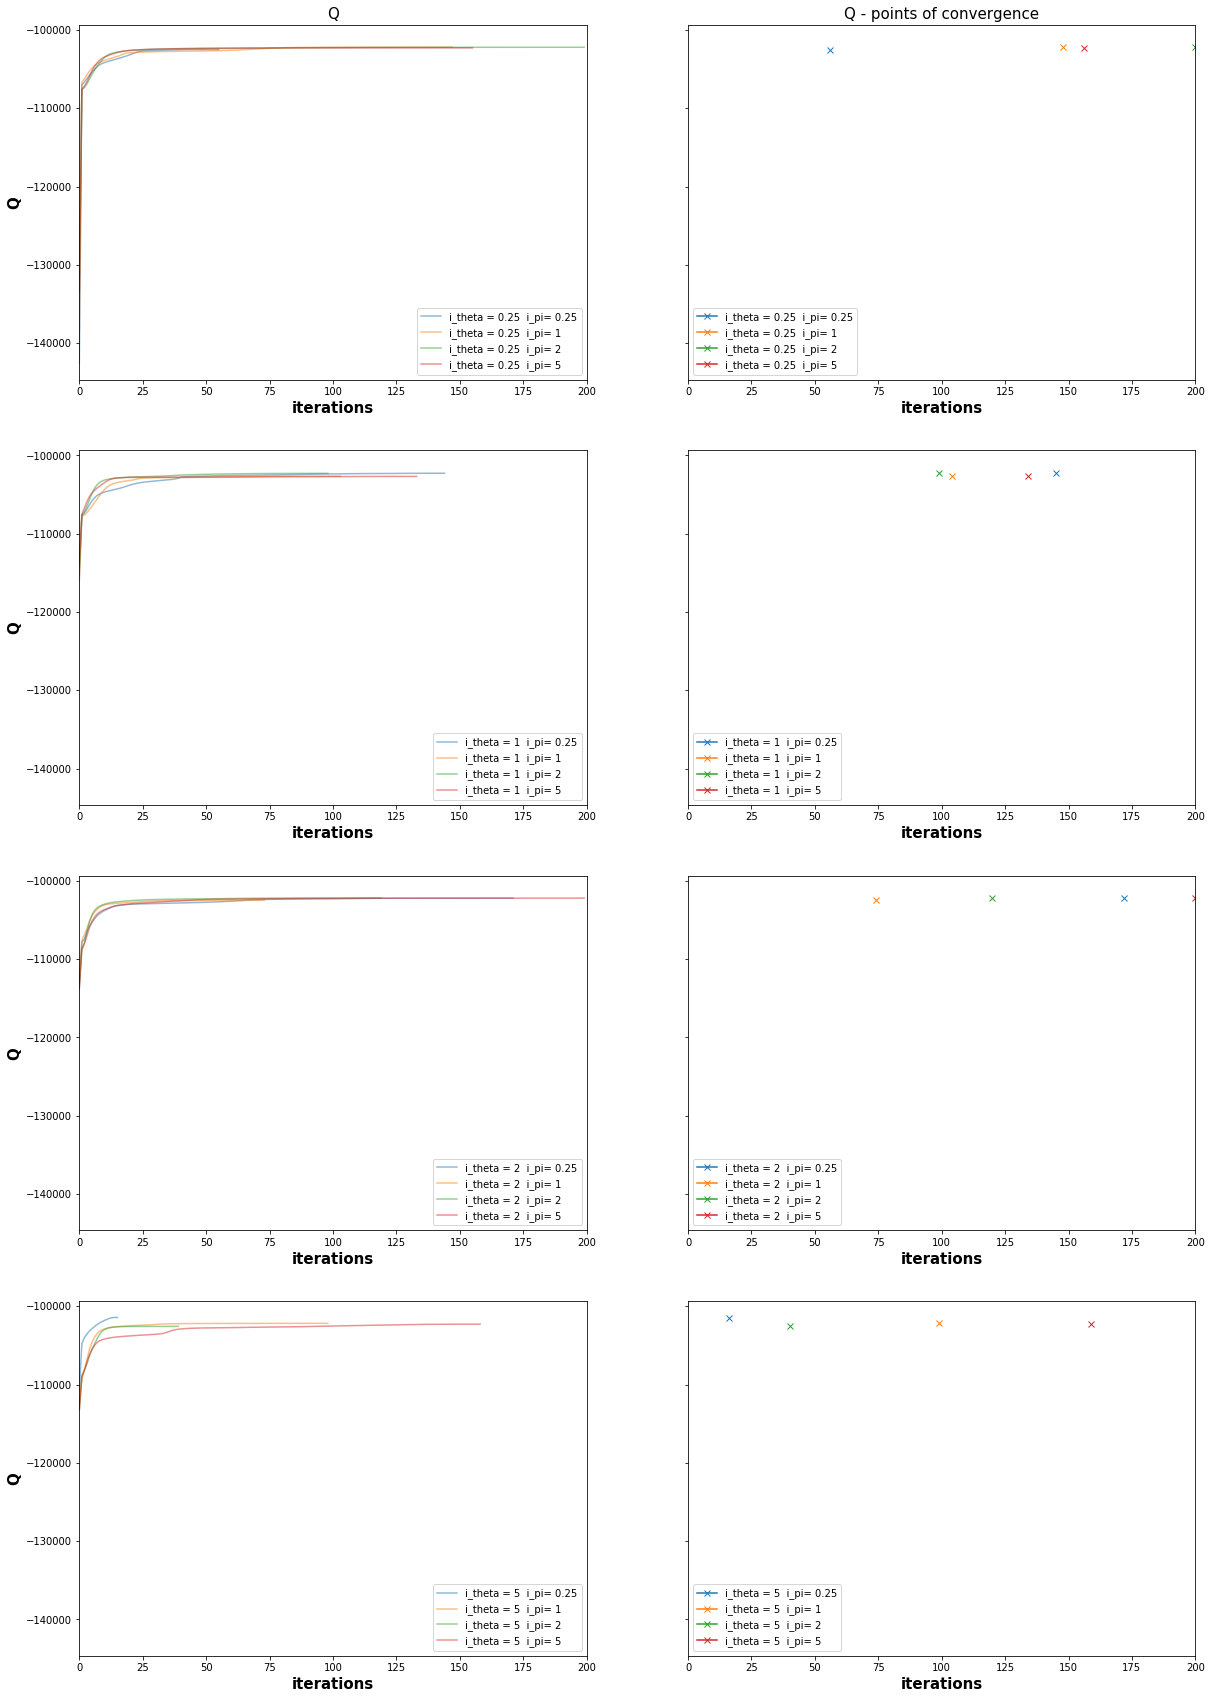

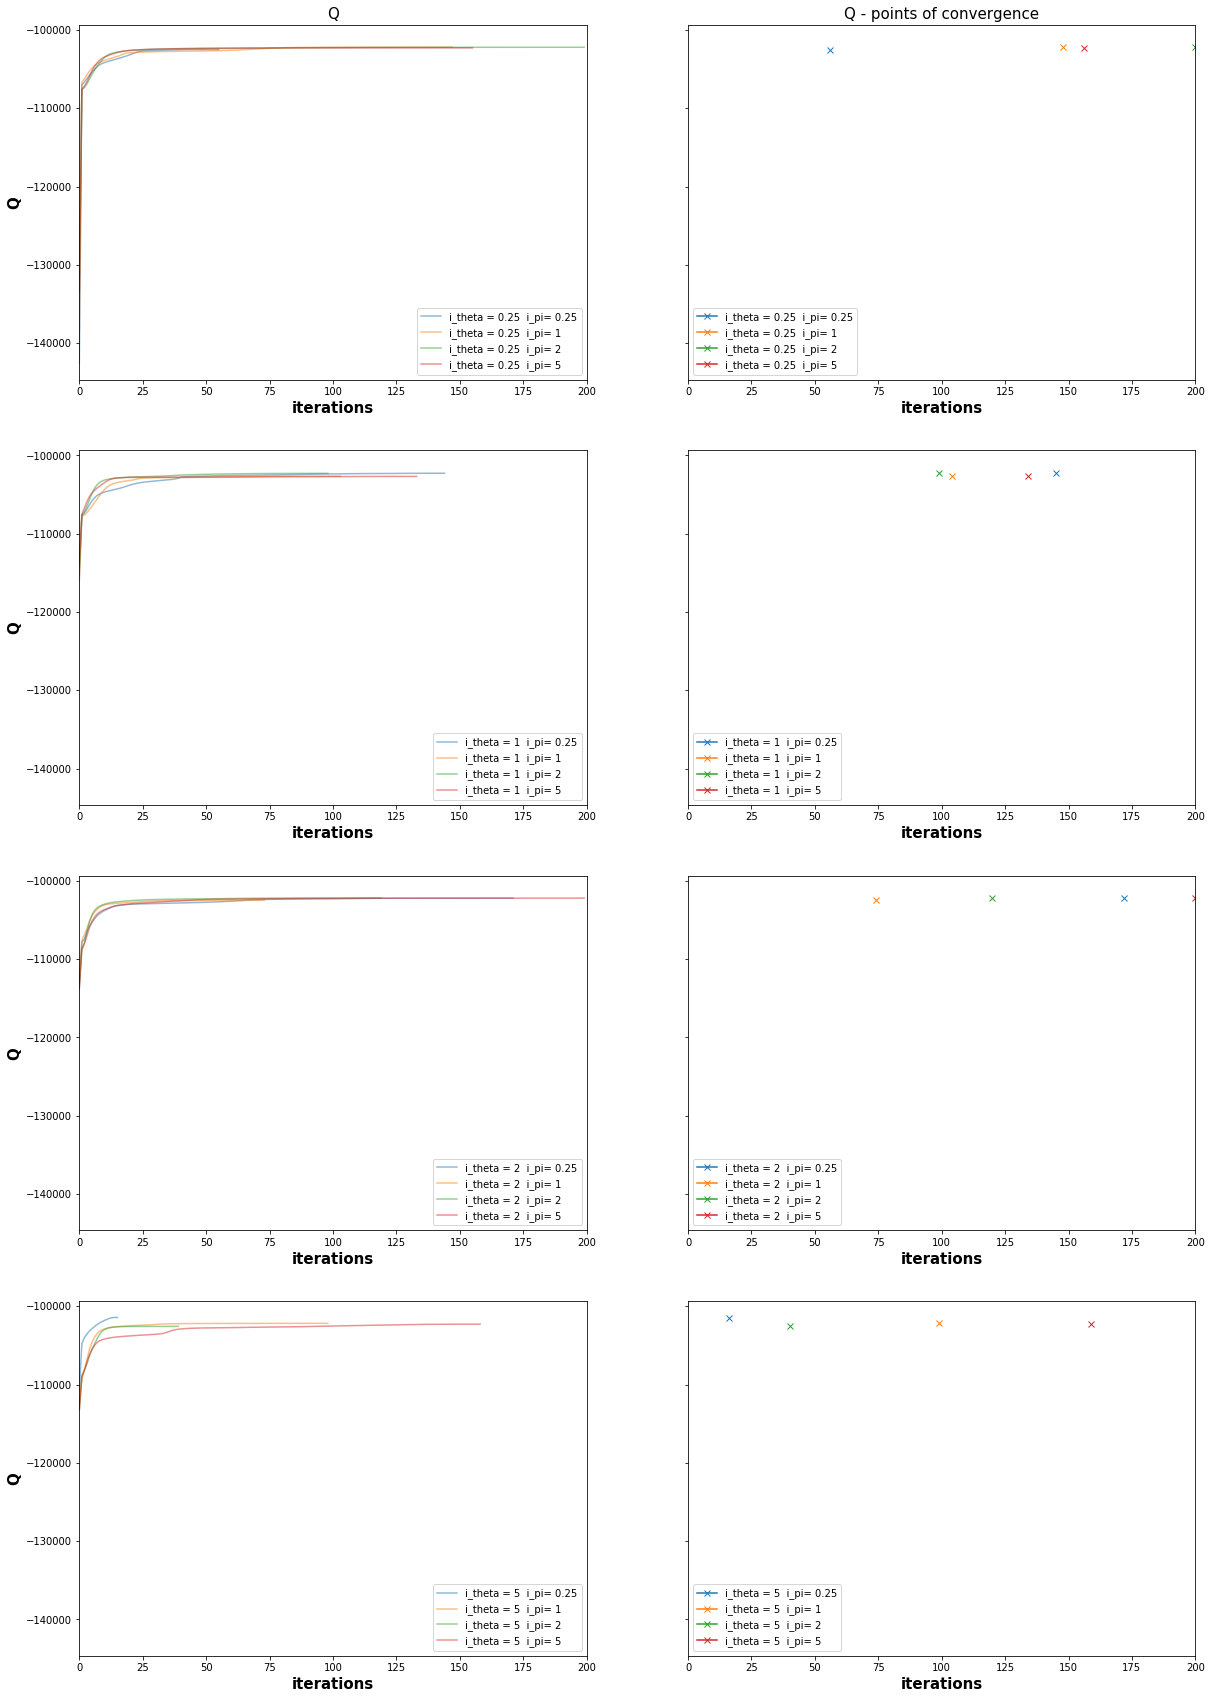

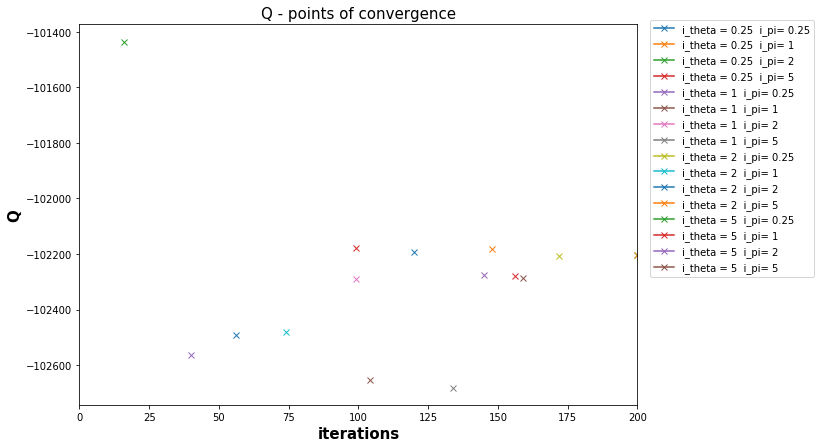

In [11]:
"""
Fix K = 5 and try different initializations.
"""
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

%matplotlib inline

K = 5 # Number of mixture components

i_pis = [1/4, 1, 2, 5]
i_thetas = [1/4, 1, 2, 5]

epochs = 200

fig_1, ax = plt.subplots(len(i_thetas), 2, figsize=(20, 30), sharey=True)
fig_2, ax_2= plt.subplots(1, 1, figsize=(10,7))

ax[0, 0].set_title("approximated log-likelihood evolution", fontsize=15)
ax[0, 1].set_title("points of convergence", fontsize=15)

ax_2.set_title("approximated log-likelihood evolution - points of convergence", fontsize=15)
ax_2.set_ylabel("Q", fontweight='bold', fontsize=15)
ax_2.set_xlabel("iterations", fontweight='bold', fontsize=15)

x= np.arange(epochs)

ax_2.set_xlim(0, epochs)

for i, i_theta in enumerate(i_thetas):
    
    ax[i, 0].set_ylabel("Q", fontweight='bold', fontsize=15)
    ax[i, 0].set_xlabel("iterations", fontweight='bold', fontsize=15)
    ax[i, 1].set_xlabel("iterations", fontweight='bold', fontsize=15)
    
    ax[i, 0].set_xlim(0,epochs)
    ax[i, 1].set_xlim(0,epochs)
    
    for j, i_pi in enumerate(i_pis):
        
        model = CategoricalEM(K, I, N, delta=0.01, epochs=epochs, init_params={'theta': i_theta, 'pi': i_pi})
        model.fit(X_matrix)
        
        ax[i, 0].plot(x[:len(model.Q_list)], model.Q_list, label=f"i_theta = {i_theta}  i_pi= {i_pi}", alpha=0.5)
        ax[i, 0].legend(loc='lower right')
        
        ax[i, 1].plot(len(model.Q_list), model.Q_list[-1], marker='x', label=f"i_theta = {i_theta}  i_pi= {i_pi}")
        ax[i, 1].legend(loc='lower left')
        
        ax_2.plot(len(model.Q_list), model.Q_list[-1], marker='x', label=f"i_theta = {i_theta}  i_pi= {i_pi}")
        ax_2.legend(loc='upper right', bbox_to_anchor=(0.825, 0.525, 0.5, 0.5))
        
        clear_output(wait=True)
        display(fig_2, fig_1)
    

#### Exercise 2.2

In [34]:
def AIC(K, I, Q):
    """
    Computes the Akaike Information Criterion.
    
    Arguments
        K: integer, number of mixture components (clusters)
        I: integer, number of words in the dictionary
        Q: float, approximation of the log-likelihood
    
    Returns 
        float, Akaike Information Criterion
    """
    return 2 * K * I - 2 * Q

In [ ]:
num_clusters = [2, 3, 5, 10]
aic = np.zeros(len(num_clusters))

i_theta = 10 # Dirichlet parameter from which the parameter is sampled for initialization
i_pi = 10 # Dirichlet parameter from which the parameter is sampled for initialization

for idx, K in enumerate(num_clusters):
    model = CategoricalEM(K, I, N, delta=0.01, epochs=200, init_params={'theta': i_theta, 'pi': i_pi})
    model.fit(X_matrix)

#### Exercise 2.3

Some useful packages:
- matplotlib https://matplotlib.org/
- seaborn https://github.com/mwaskom/seaborn
- wordcloud https://github.com/amueller/word_cloud
- probvis https://github.com/psanch21/prob-visualize



In [49]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline

tweet_array = np.array(df_data['tweet'].values)

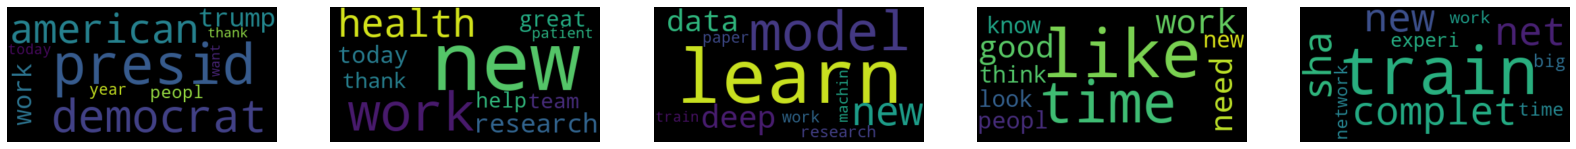

In [50]:
# Show the 10 most representative words for each topic using a cloud of words

fig, ax = plt.subplots(1, K, figsize=(28,15))

for k in range(K):
    theta_k = model.theta_matrix[k]
    
    # get indices of 10 most representative words
    ind = np.argsort(-theta_k)[:10]
    
    words = [dictionary[i] for i in ind]     
    frequencies = {word:freq for word, freq in zip(words, theta_k[ind])}
    
    # generate wordcloud
    wordcloud = WordCloud().generate_from_frequencies(frequencies)
    
    ax[k].imshow(wordcloud, interpolation='bilinear')
    ax[k].axis("off")

In [54]:
# Show the 10 most relevant documents for each topic.

for k in range(K):
    prob_zn_k = model.r_matrix[:, k]
    
    # get indices of 10 most relevant documents
    ind = np.argsort(-prob_zn_k)[:10]
    
    for i, idx in enumerate(ind):
        print(f"\nCluster {k} \t tweet {i+1}:")
        print(tweet_array[idx])


Cluster 0 	 tweet 1:
Hello Arizona! Great to be here in the Grand Canyon state with Governor @dougducey and @SenMcSallyAZ to promote a trade deal that will benefit all Americans. The Trump Administration will never stop working for YOU, the American people! pic.twitter.com/kEgZuMpV92

Cluster 0 	 tweet 2:
Business owners and hard-working Americans tell us every day how great the economy is under President Trump.

But now the Left is openly wishing for a “recession!”

It’s the clearest example yet: Democrats are desperate to stop the President, even if it hurts America.

Cluster 0 	 tweet 3:
Why do Democrats and the media keep falsely claiming President Trump pressured Ukraine? President Zelensky has repeatedly said that he wasn’t pushed.

Cluster 0 	 tweet 4:
Comey:
-Opened Trump-Russia investigation
-Put Peter “we’ll stop Trump” Strzok in charge
-Allowed Dossier to be used
-Leaked memos to get Special Counsel appointed
-Tried to trap the President at Trump Tower meeting

All while te

In [18]:
# Show the evolution of Q over the epochs